<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Исследовательский-анализ-данных:" data-toc-modified-id="Исследовательский-анализ-данных:-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Исследовательский анализ данных:</a></span></li><li><span><a href="#Обучение-модели:" data-toc-modified-id="Обучение-модели:-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение модели:</a></span></li><li><span><a href="#Анализ-обученной-модели:" data-toc-modified-id="Анализ-обученной-модели:-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Анализ обученной модели:</a></span></li><li><span><a href="#Общий-вывод:" data-toc-modified-id="Общий-вывод:-4"><span class="toc-item-num">4&nbsp;&nbsp;</span><strong>Общий вывод:</strong></a></span></li></ul></div>

____
# Определение возраста покупателей

___
**Описание задачи:**

Сетевому супермаркету «Хлеб-Соль» необходимо внедрить систему компьютерного зрения, которая по фотографии будет определять приблизительный возраст человека. 

Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы решать следующие задачи:
1. Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
2. Контролировать добросовестность кассиров при продаже алкоголя.

**Основная цель:**
- Построить и обучить свёрточную нейронную сеть со значением `MAE` на тестовой выборке не больше 8.

**Описание данных:**
- В нашем распоряжении набор фотографий людей с указанием возраста.

**План работы:**
1. Провести исследовательский анализ набора фотографий.
2. Подготовить данные к обучению.
3. Обучить нейронную сеть и рассчитать её качество.
__________

Для начала импортируем все необходимые библиотеки:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing.image import ImageDataGenerator 

import warnings

In [2]:
warnings.filterwarnings('ignore')
SEED=777

___
## Исследовательский анализ данных:

Для работы с большим количеством изображений создадим `ImageDataGenerator` и загрузим данные:

In [3]:
data = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(dataframe=data,
                                                   directory='/datasets/faces/final_files/',
                                                   x_col='file_name',
                                                   y_col='real_age',
                                                   target_size=(224, 224),
                                                   batch_size=32,
                                                   class_mode='raw',
                                                   seed=SEED) 

Found 7591 validated image filenames.


In [4]:
data.tail()

,file_name,real_age
7586,007608.jpg,14
7587,007609.jpg,37
7588,007610.jpg,28
7589,007611.jpg,20
7590,007612.jpg,47


Наша выборка состоит из 7591 изображения.

Табличные данные содержат:
* Наименование файла. 
* Реальный возраст человека на фотографии.
________

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [6]:
data.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


Судя из описания имеем следующие наборы возрастов:
* Минимальный возраст человека - 1 год
* Средний возраст - 31 год
* Максимальный - 100 лет
_________

In [7]:
print('Количество пропусков в столбцах:', '\n', data.isna().sum())
print()
print('Количество дубликатов во фрейме:', data.duplicated().sum())

Количество пропусков в столбцах: 
 file_name    0
real_age     0
dtype: int64

Количество дубликатов во фрейме: 0


____
Пропусков и дубликатов не выявлено.
____

**Построим график распределения возрастов:**

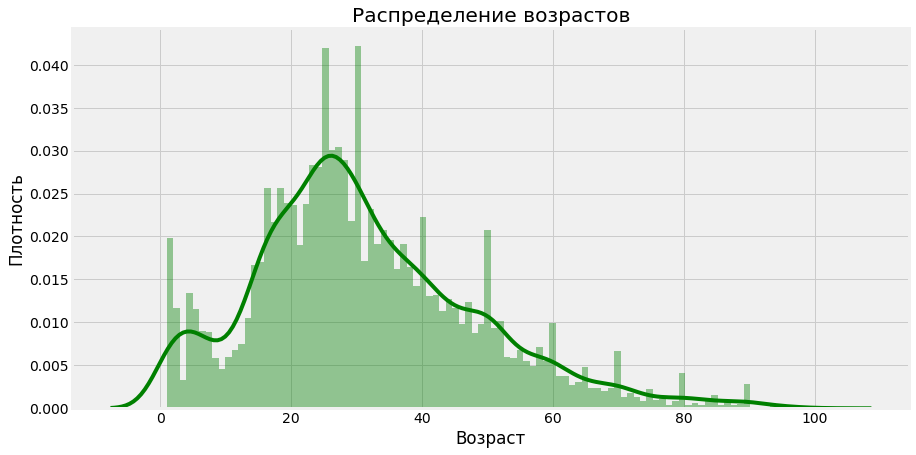

In [8]:
plot = plt.figure(figsize=(15,7))
plt.style.use('fivethirtyeight')

ax = sns.distplot(data['real_age'], color='green', bins=100)
ax.set(title='Распределение возрастов',
       xlabel='Возраст',
       ylabel='Плотность')

plt.show()

___
**Построим диаграмму размаха:**

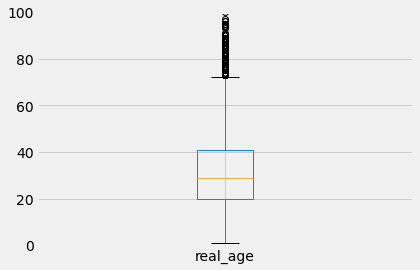

In [9]:
data.boxplot(column=['real_age'])
plt.ylim(0, 100)
plt.show()

**Исходя из графика распределения и ящика с усами можно сказать, что:**
* Представлены все возрастные группы.
* Наибольшее количество людей находится в диапазоне от 20 до 30 лет.
* Значение возраста свыше 70 лет можно отнести к выбросам, однако, это редкие, а не ошибочные наблюдения и могут также наблюдаться в тестовой выборке.
* Наблюдаются пиковые значения в возрастах, кратным 10 годам.
___

**Посмотрим, как устроен датасет и выведем 16 фотографий со значением таргета к ним:**

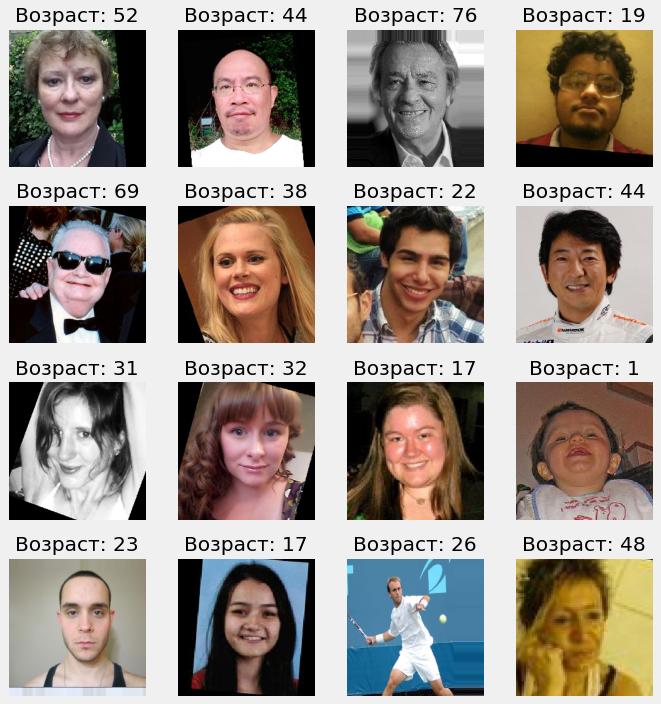

In [10]:
features, target = next(train_gen_flow)
plot = plt.figure(figsize=(10,10))

for img in range(16):
    plot.add_subplot(4, 4, img+1)
    plt.imshow(features[img])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.title('Возраст: ' + str(target[img]))

**Вывод:**
* Присутствуют люди всех гендеров и большинства возрастных групп.
* Имеем как цветные, так и ч\б фотокарточки.
* Некоторые снимки имеют рамки, ротацию и разный масштаб.

Общая ориентация фотографий примерно одинакова - в некоторых фото их уже повернули за нас, чтобы выровнять положение лица, значит нам их не обязательно поворачивать, а начальный размер изображений отличается, в силу того, что визуально заметно различное качество фото, где-то есть черные рамки (они не несут полезной информации). 

В итоге, размер изображений мы приведем к единому перед обучением модели.
___

___
## Обучение модели:

Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке.

```python

import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

SEED = 777

def load_train(path):
	data = pd.read_csv(path + 'labels.csv')
	train_datagen = ImageDataGenerator(validation_split=0.25, 
		                               horizontal_flip=True,
		                               rescale=1/255)
	train_data = train_datagen.flow_from_dataframe(dataframe=data,
		                                           directory=path + 'final_files/',
		                                           x_col='file_name',
		                                           y_col='real_age',
		                                           target_size=(224, 224),
		                                           batch_size=32,
		                                           class_mode='raw',
		                                           subset='training',
		                                           seed=SEED)
	return train_data

def load_test(path):
	data = pd.read_csv(path + 'labels.csv')
	test_datagen = ImageDataGenerator(validation_split=0.25, 
		                               rescale=1/255)
	test_data = test_datagen.flow_from_dataframe(dataframe=data,
		                                         directory=path + 'final_files/',
		                                         x_col='file_name',
		                                         y_col='real_age',
		                                         target_size=(224, 224),
		                                         batch_size=32,
		                                         class_mode='raw',
		                                         subset='validation',
		                                         seed=SEED)
	return test_data

def create_model(input_shape):
	backbone = ResNet50(input_shape=input_shape, 
		                weights='imagenet',
		                include_top=False)
	model = Sequential()
	model.add(backbone)
	model.add(GlobalAveragePooling2D())
	model.add(Dense(1, activation='relu'))
	optimizer = Adam(lr=0.0005)
	model.compile(loss='mse',
		          optimizer=optimizer,
		          metrics=['mae'])

	return model

def train_model(model,
	            train_data,
	            test_data,
	            batch_size=None,
	            epochs=10,
	            steps_per_epoch=None,
	            validation_steps=None):
    
    if steps_per_epoch is None:
    	steps_per_epoch = len(train_data)
    if validation_steps is None:
    	validation_steps = len(test_data)

    model.fit(train_data, 
    	      validation_data=test_data,
    	      batch_size=batch_size,
    	      epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

```

___
```

Train for 178 steps, validate for 60 steps
Epoch 1/10
2023-05-02 13:46:16.230777:  ...
2023-05-02 13:46:16.532282:  ...
178/178 - 61s - loss: 203.7643 - mae: 10.7093 - val_loss: 359.2019 - val_mae: 14.1524
Epoch 2/10
178/178 - 61s - loss: 113.5421 - mae: 8.1354 - val_loss: 344.8175 - val_mae: 13.8305
Epoch 3/10
178/178 - 60s - loss: 88.9721 - mae: 7.1948 - val_loss: 374.1549 - val_mae: 14.4979
Epoch 4/10
178/178 - 60s - loss: 71.8845 - mae: 6.4710 - val_loss: 228.3052 - val_mae: 11.3650
Epoch 5/10
178/178 - 60s - loss: 55.6794 - mae: 5.6751 - val_loss: 107.7961 - val_mae: 8.1185
Epoch 6/10
178/178 - 57s - loss: 48.3586 - mae: 5.2620 - val_loss: 124.7899 - val_mae: 9.0546
Epoch 7/10
178/178 - 61s - loss: 38.1453 - mae: 4.7516 - val_loss: 93.2971 - val_mae: 7.1009
Epoch 8/10
178/178 - 61s - loss: 32.1754 - mae: 4.3169 - val_loss: 86.3766 - val_mae: 7.0769
Epoch 9/10
178/178 - 62s - loss: 30.6079 - mae: 4.2203 - val_loss: 87.2514 - val_mae: 6.8801
Epoch 10/10
178/178 - 62s - loss: 23.8285 - mae: 3.7990 - val_loss: 81.1960 - val_mae: 6.6174
WARNING:tensorflow:sample_weight modes were coerced from
  ...
  ['...']
    to  
60/60 - 11s - loss: 81.1960 - mae: 6.6174
Test MAE: 6.6174

```

___
## Анализ обученной модели:

**Основная цель работы** - *Построить и обучить свёрточную нейронную сеть со значением MAE на тестовой выборке не больше 8* - выполнена.
Значение метрики `МАE` на тестовой выборке составило `6.6174`, но исходя из целей заказчика не все так однозначно. 

*Еще раз обозначим эти задачи :*
1. Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
2. Контролировать добросовестность кассиров при продаже алкоголя.

Для первой задачи значение метрики качества в 6.6 лет можно считать хорошим показателем, т.к для маркетинговой компании с рекомендательной системой абсолютная точность не так важна и не будет критичной для отнесения к той или иной возрастной группе и вариации покупательских предпочтений.

С другой стороны - для второй задачи , вероятно, погрешность в 6.6 лет будет велика. 
Здесь уже необходима высокая точность модели в возрастном промежутке около 18 лет и возможно потребуется более сложная модель, детальная настройка и более крупный датасет с акцентом на изображения подростков и молодых людей.

___

## **Общий вывод:**
___

**Этап 1. Исследовательский анализ:**

* Минимальный возраст человека - `1` год
* Средний возраст - `31` год
* Максимальный - `100` лет
* Пропусков и дубликатов не обнаружено.
 
 *Представлены все возрастные группы:*
* Наибольшее количество людей находится в диапазоне от `20` до `30` лет.
* Значение возраста свыше 70 лет можно отнести к выбросам, однако, это редкие, а не ошибочные наблюдения и могут также наблюдаться в тестовой выборке.
* Наблюдаются пиковые значения в возрастах, кратным 10 годам:
  * Пики в районе "юбилейных" лет могут быть связаны с тем, что настоящий возраст был неизвестен тому, кто размечал датасет, и он попросту округлял его.
* Присутствуют люди всех гендеров и большинства возрастных групп.
* Имеем как цветные, так и ч\б фотокарточки.
* Некоторые снимки имеют рамки, ротацию и разный масштаб.
___
**Этап 2. Обучение модели:**
* Обучена сверточная нейронная сеть:
  * Алгоритм обучения и подбора гиперпараметров - `ADAM`,
  * Архитектура `ResNet50`.
* Средняя абсолютная ошибка *MAE* на тестовой выборке составила - `6.6174`
___
**Рекомендации:**
- Обучающая выборка относительно небольшая, для дальнейших исследований и увеличения метрики качества необходимо нарастить ее, применяя аугментации, используя: 
  - поворот изображения,
  - смещения по ширине и высоте,
  - изменение яркости и канала изображения,
  - сдвиг и масштабирование.

- Качество данных на входе: оценить еще раз возраст по фото.
- Модель сильно ошибается на сегменте пожилых людей, зато почти идеально работает с детьми. 
  - Т.о. произведя анализ ошибок модели - мы можем понять, каких возрастов фото было бы хорошо добавить в выборку для дообучения.
- Дополнительно изучить распределение целевого признака, возможно, что выборка была составлена неслучайным образом (видна небольшая бимодальность), посмотреть, каких возрастных групп представлено мало, чтобы их потом добавить в выборку.
___